In [3]:
import numpy as np
import pygimli as pg

from pygimli.physics import ert
#from pybert.importer.exportData import exportRes2dInv
from pygimli.physics.ert.importData import importRes2dInv
import matplotlib.pyplot as plt
import pygimli.meshtools as mt
from pygimli.frameworks import PriorModelling, JointModelling
from scipy.interpolate import interp1d
import pandas as pd
import pickle
from pygimli.viewer.mpl import draw1DColumn


In [4]:
dir='//smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/'

In [5]:
data_err_topo = ert.load('//smb.isipd.dmawi.de/projects/sparc/data/Sensors_Mobile/202307_DEPTHAW_InuvikTuk/IRISSyscalProSwitch/res2Dinv/ERT_data_eastern_amphibious_DAT_no_std_filter_with_err.txt')
err = data_err_topo['err']+0.02
y = pg.y
data = ert.load('//smb.isipd.dmawi.de/projects/sparc/data/Sensors_Mobile/202307_DEPTHAW_InuvikTuk/IRISSyscalProSwitch/res2Dinv/ERT_data_eastern_amphibious_DAT_no_std_filter_with_err.dat')

24/02/25 - 22:38:28 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv


In [3]:
data.save('//smb.isipd.dmawi.de/projects/sparc/data/Sensors_Mobile/202307_DEPTHAW_InuvikTuk/IRISSyscalProSwitch/res2Dinv/ERT_data_eastern_amphibious_DAT_no_std_filter_with_err.txt', "a b m n rhoa")

1

24/02/25 - 22:38:31 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 1): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\1792169925053016080
24/02/25 - 22:38:31 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (9.2s x 1): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\5525935032422878937


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2307fa55250>)

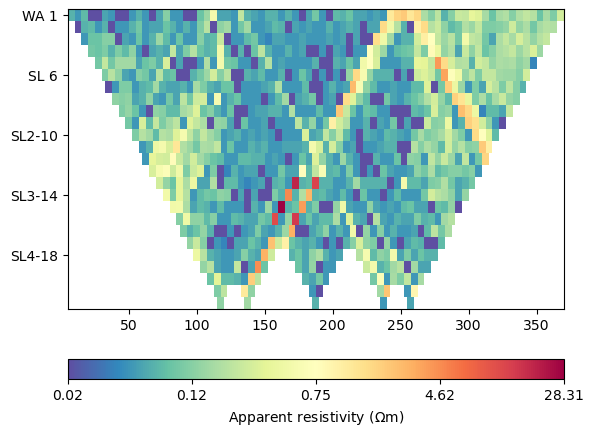

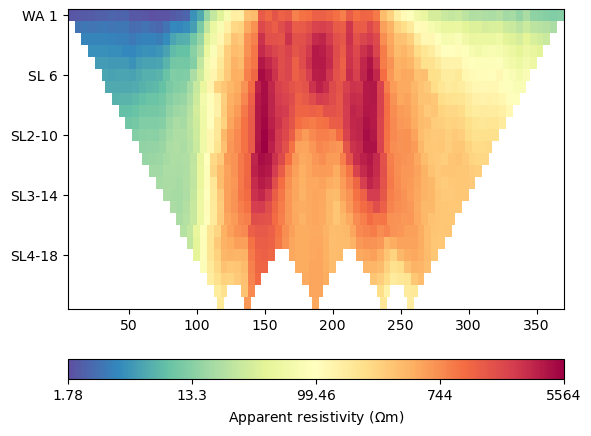

In [6]:

mgr = ert.ERTManager(data)
data['err'] = err
#data.setSensorPositions(pg.meshtools.interpolateAlongCurve(data.additionalPoints(), pg.x(data)))
data['k'] = ert.createGeometricFactors(data)
data['r'] = data['rhoa']/data['k']
data.setSensorPositions(pg.meshtools.interpolateAlongCurve(data.additionalPoints(), pg.x(data)))
data['k_topo'] = ert.createGeometricFactors(data, numerical=True)
data['rhoa'] = data['r']*data['k_topo']
#data.markInvalid(data['err']>=5)
#data['err'] = ert.estimateError(data, relativeError=0.04, absoluteUError=6e-5)
ert.show(data, data['err'])
ert.show(data)

In [13]:
np.mean(data['rhoa'])

1087.7132780025472

25/02/25 - 09:12:34 - pyGIMLi - INFO - Use median(data values)=605.1544214116204
25/02/25 - 09:12:34 - pyGIMLi - INFO - Created startmodel from forward operator: 4793, min/max=605.154421/605.154421
25/02/25 - 09:12:34 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002307F34C2C0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002307F34C540>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002307F34C400>
min/max (data): 1.78/5564
min/max (error): 2%/2831%
min/max (start model): 605/605
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1725.27
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   79.46 (dPhi = 89.70%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   49.34 (dPhi = 32.83%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   30.11 (dPhi = 25.23%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =   31.16 (dPhi = 0.05%) lam: 20.0
################

Text(129.2041457109214, 0.5, 'y (m)')

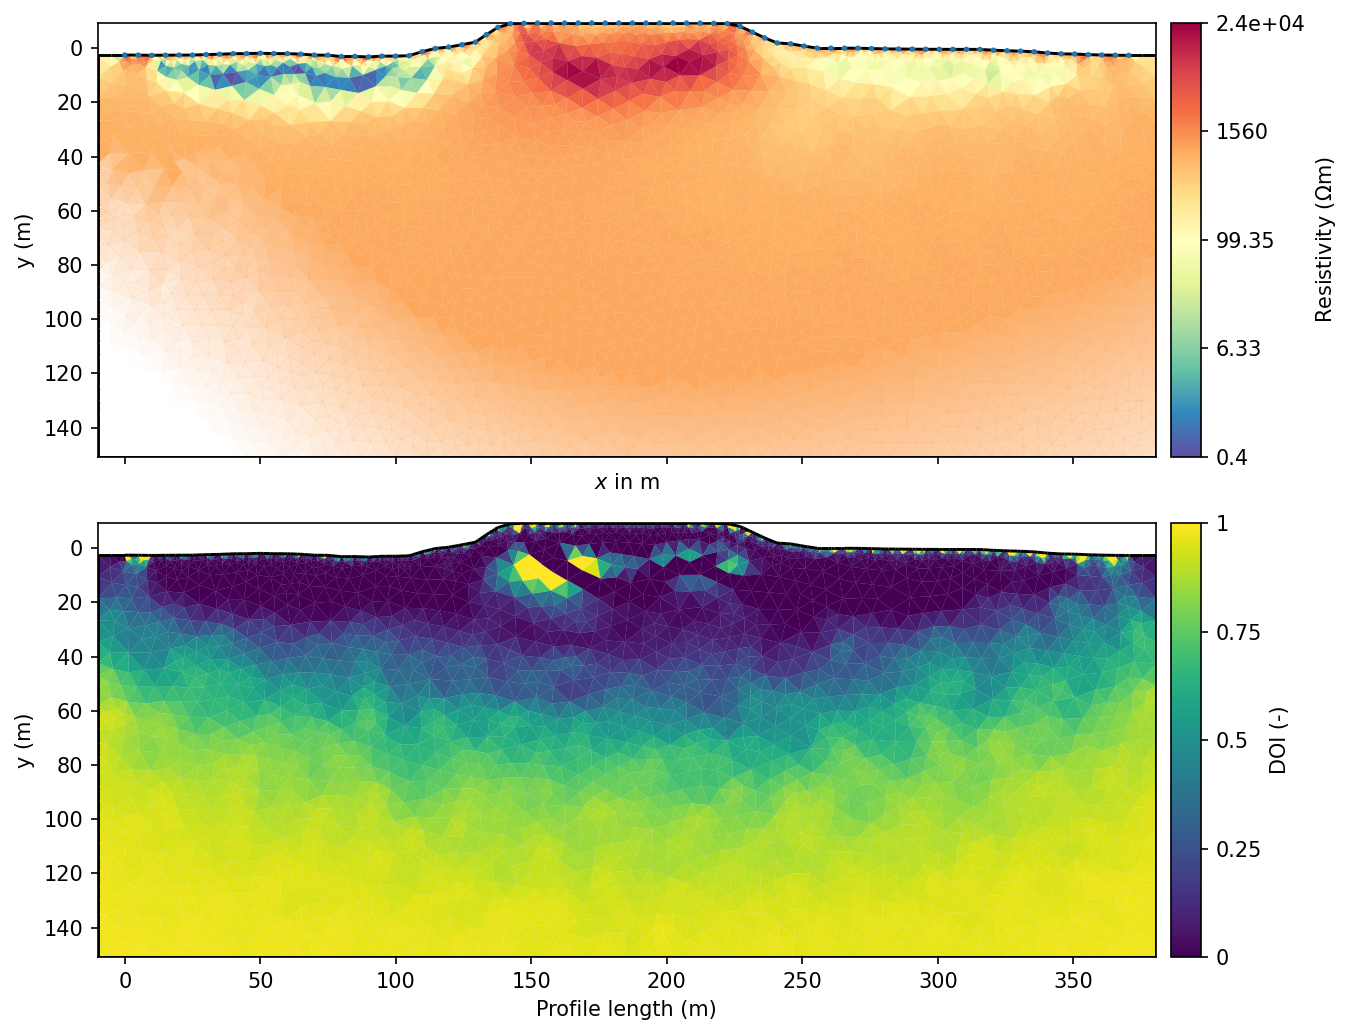

In [14]:
inv = mgr.invert(lam=20, verbose=True, paraDX=0.25, paraDZ=0.25, paraMaxCellSize=25)
def run_inv(referencemodel):
    # Set reference model as startmodel
    mgr.inv.inv.setModel(referencemodel)

    # Set reference model
    rm = mgr.inv.fop.regionManager()
    rm.setConstraintType(10) # 0 = reference model, 1 = first-order smoothing (default), 10 = both
    rm.fillConstraints(mgr.inv.fop.constraints())
    mgr.inv.inv.setReferenceModel(referencemodel)
    model = mgr.inv.inv.run()
    return model

def compute_DOI(ref1, ref2):
    m1 = run_inv(ref1)
    m2 = run_inv(ref2)

    R = (m1 - m2) / (m1r - m2r)
    return R


m1r = np.ones(mgr.paraDomain.cellCount()) * 100
m2r = np.ones(mgr.paraDomain.cellCount()) * 10000

DOI = compute_DOI(m1r, m2r)

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10,7), dpi=150, sharex=True)

mgr.showResult(ax=ax1, orientation="vertical")
#ax1.set_xlabel("Profile length")
ax1.set_ylabel("y (m)")
pg.show(mgr.paraDomain, DOI, ax=ax2, cMin=0, cMax=1, orientation="vertical", label="DOI (-)")
ax2.set_xlabel("Profile length (m)")
ax2.set_ylabel("y (m)")


Text(87.33333333333333, 0.5, 'y (m)')

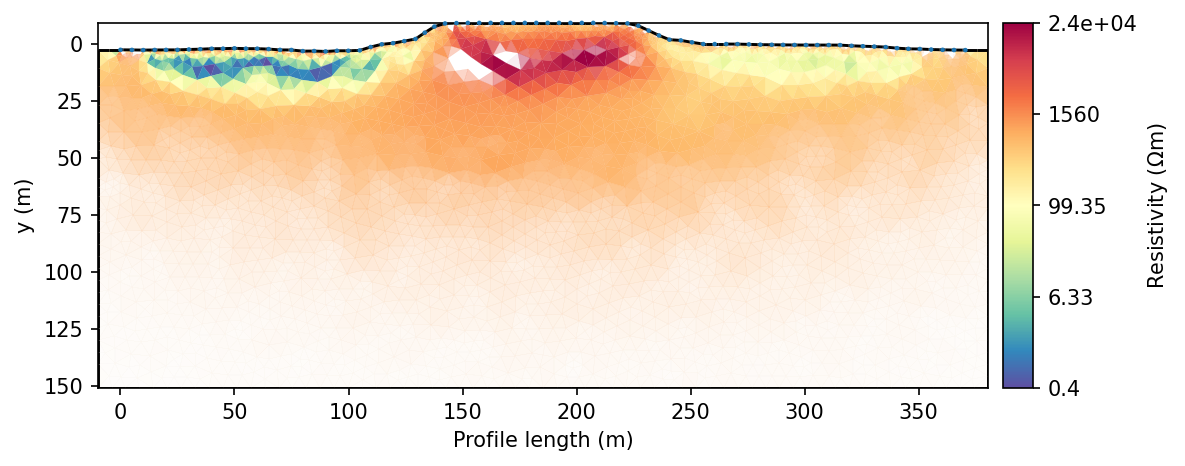

In [22]:
import numpy as np

def doi_to_transparency(doi, doiThreshold=0.2, maxDOI=1):
    """
    Convert DOI values into transparency values for visualization.

    Parameters:
        doi (array-like): DOI values.
        doiThreshold (float): DOI value below which transparency is 1 (fully opaque).
        maxDOI (float): DOI value at which transparency is 0 (fully transparent).

    Returns:
        array-like: Transparency values (1 = opaque, 0 = fully transparent).
    """
    D = np.asarray(doi)
    
    # Initialize alpha (transparency) array
    alpha = np.ones_like(D)  # Default to fully opaque

    # Apply gradual transparency beyond the DOI threshold
    mask = D > doiThreshold
    alpha[mask] = 1.0 - (D[mask] - doiThreshold) / (maxDOI - doiThreshold)

    # Cap values to ensure transparency is within [0,1]
    alpha = np.clip(alpha, 0, 1)
    
    return alpha



#opacity = np.ones(mgr.paraDomain.cellCount())
#opacity[DOI > 0.2] = 0
opacity = doi_to_transparency(DOI)
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
mgr.showResult(ax=ax, coverage=opacity, orientation = "vertical")
#ax.set_title("Inverse model with cutoff")
ax.set_xlabel("Profile length (m)")
ax.set_ylabel("y (m)")

Text(87.33333333333333, 0.5, 'y (m)')

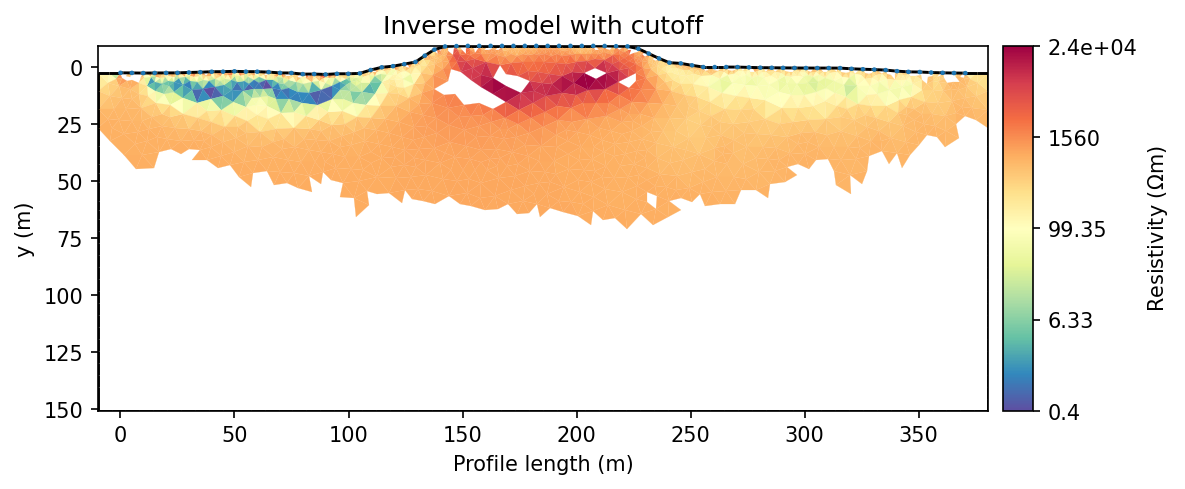

In [21]:
opacity = np.ones(mgr.paraDomain.cellCount())
opacity[DOI > 0.5] = 0
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=150)
mgr.showResult(ax=ax, coverage=opacity, orientation = "vertical")
ax.set_title("Inverse model with cutoff")
ax.set_xlabel("Profile length (m)")
ax.set_ylabel("y (m)")

0 -10.0 -2.524 0.0
1 -10.0 -150.85846355054932 0.0
2 380.5167860041571 -150.85846355054932 0.0
3 380.5167860041571 -2.6517491488864673 0.0
4 -1492.0671440166284 -2.524 0.0
5 -1492.0671440166284 -1632.797858418291 0.0
6 1862.5839300207854 -2.6517491488864673 0.0
7 1862.5839300207854 -1632.9256075671776 0.0
8 0.0 -2.524 0.0
9 1.2499516028108906 -2.5349995741047358 0.0
10 3.749854808432672 -2.5569987223142077 0.0
11 4.999806411243562 -2.5679982964189434 0.0
12 6.249658216467371 -2.587245694797942 0.0
13 8.749361826914988 -2.625740491555939 0.0
14 9.999213632138797 -2.6449878899349377 0.0
15 11.249135228533955 -2.630993997401589 0.0
16 13.74897842132427 -2.603006212334891 0.0
17 14.998900017719428 -2.5890123198015424 0.0
18 16.24887898062829 -2.581760956840592 0.0
19 18.748836906446023 -2.567258230918692 0.0
20 19.998815869354885 -2.5600068679577417 0.0
21 21.24880946594051 -2.556006118763748 0.0
22 23.74879665911176 -2.548004620375762 0.0
23 24.998790255697386 -2.5440038711817685 0.0
24 2

(-130.0, 381.0)

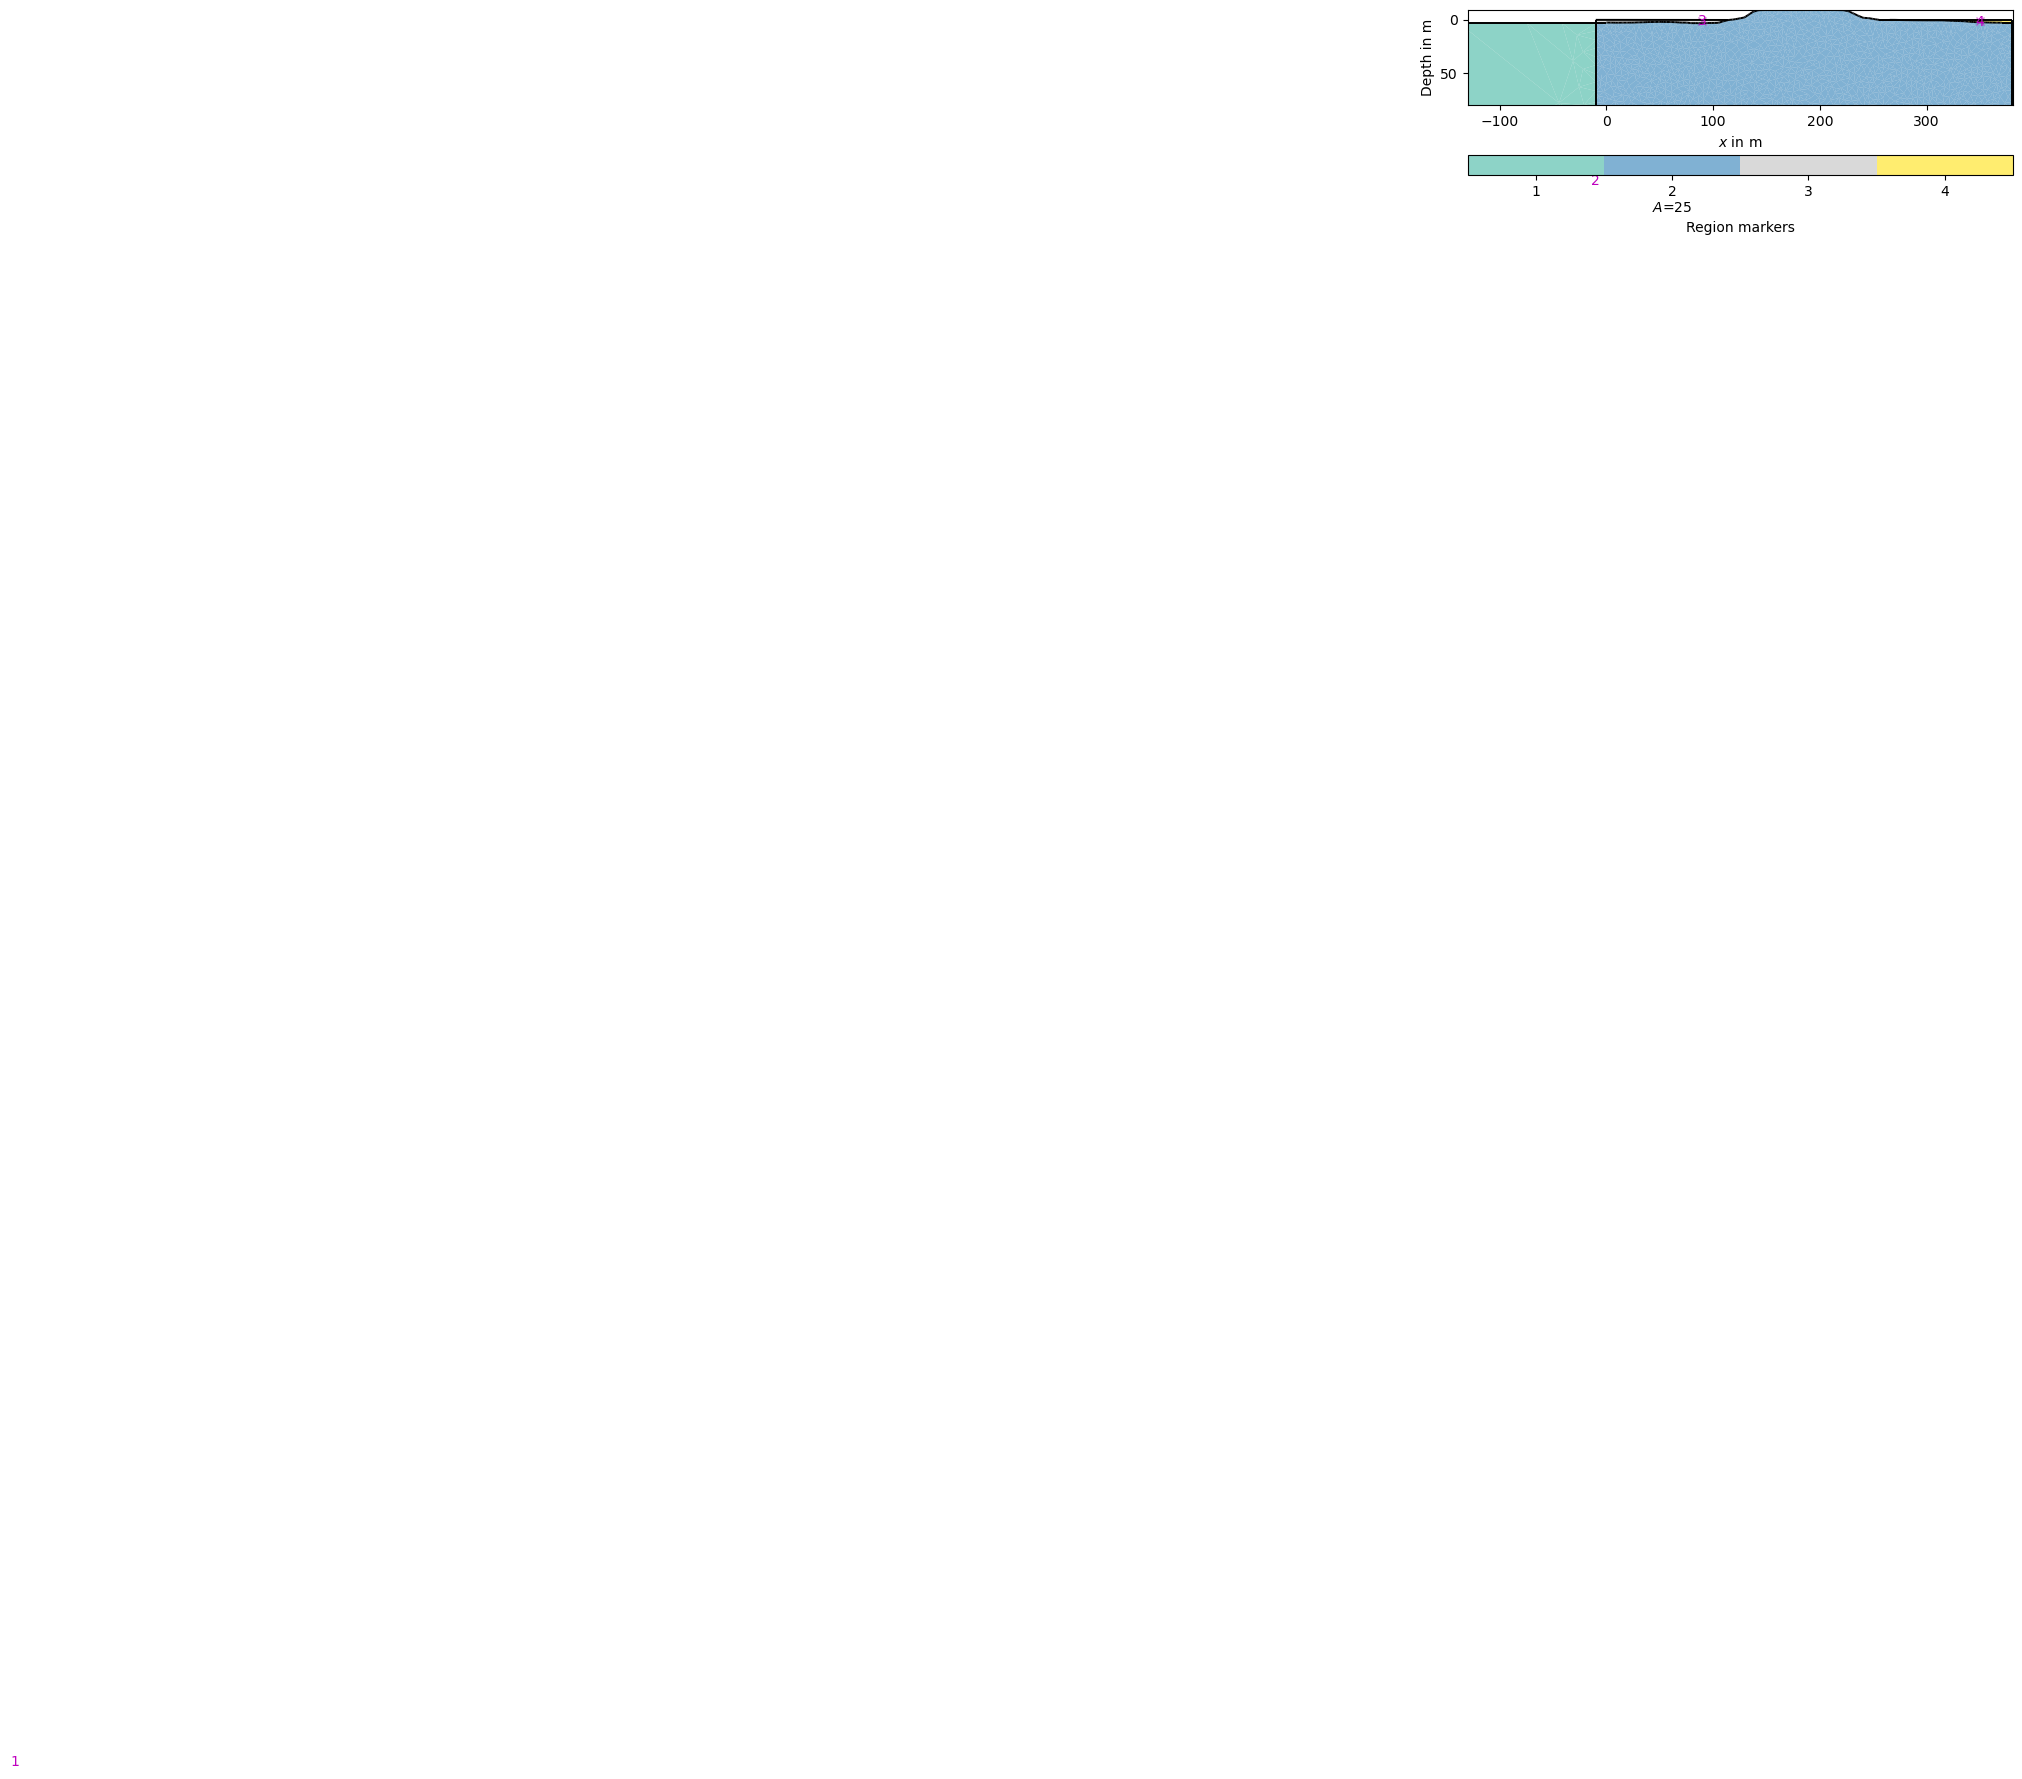

In [117]:
plc = mt.createParaMeshPLC(data,paraDX = 0.25, paraDZ= 0.25, paraMaxCellSize=25)
for i, n in enumerate(plc.nodes()[:]):
    #ax.text(n.x(), n.y(), str(i))
    print(i, n.x(), n.y(), n.z())
for nr, marker in enumerate(plc.regionMarkers()):
    print('Position marker number {}:'.format(nr + 1), marker.x(), marker.y(),
          marker.z())


plc.createNode(-10, 0, 0, marker=234)
#plc.createNode(113.5, 0, 0, marker=235)

plc.createNode(380.5167860041571, 0, 0, marker=235)

plc.createEdge(plc.node(234), plc.node(77), marker=-1)
plc.createEdge(plc.node(234), plc.node(0), marker=-1)
plc.createEdge(plc.node(164), plc.node(235), marker=-1)
plc.createEdge(plc.node(235), plc.node(3), marker=-1)

plc.addRegionMarker([90, -1], marker=3)  
plc.addRegionMarker([350, -1.5], marker=4)  

ax, _ = pg.show(plc)
ax.set_ylim(-80)
ax.set_xlim(-130,381)


(-30.0, 410.0)

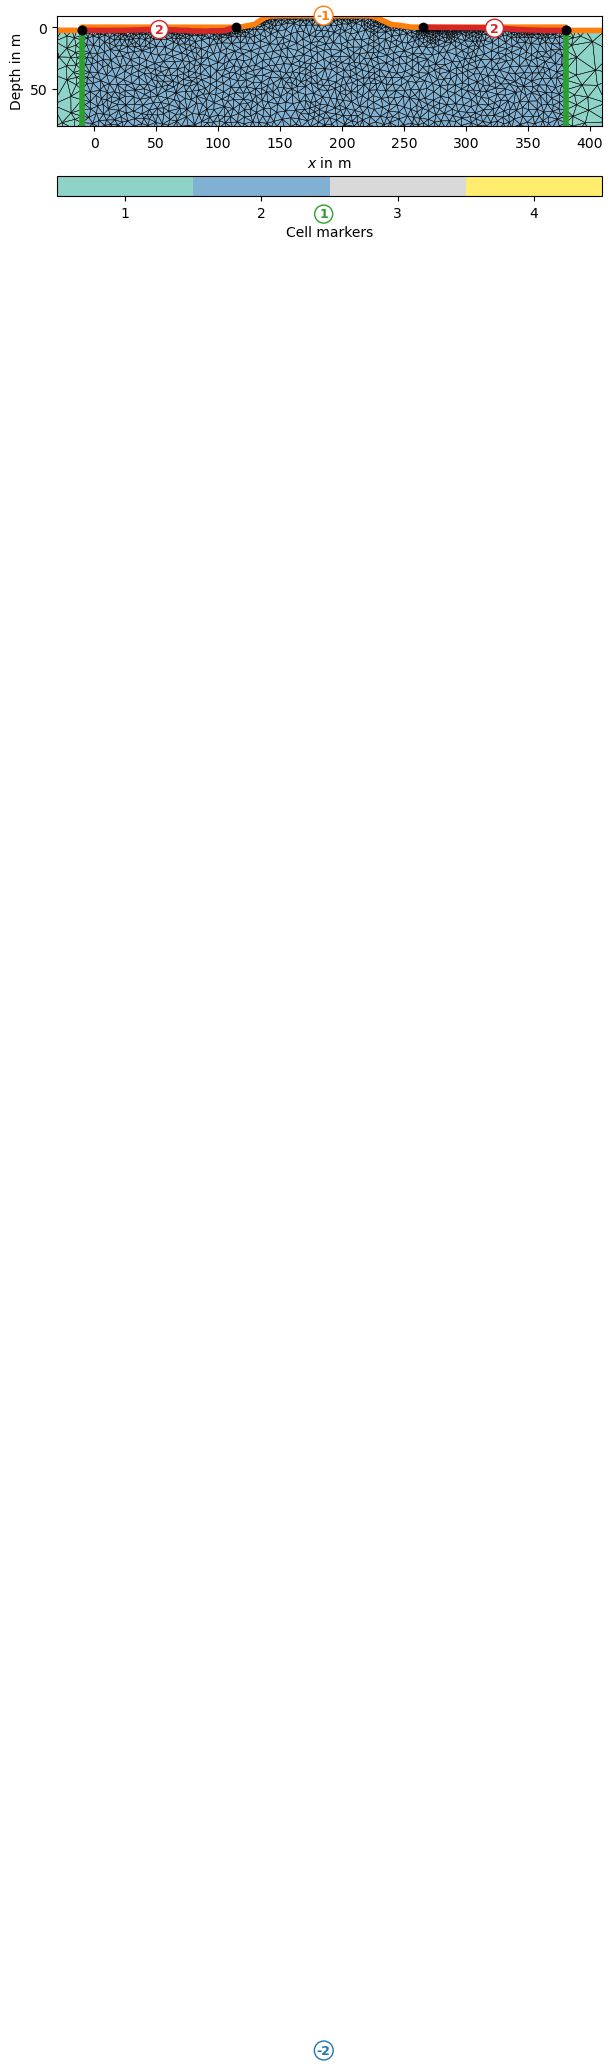

In [118]:
mesh = mt.createMesh(plc)
for b in mesh.boundaries():
    if b.marker() == -1 and not b.outside():
        b.setMarker(2)

#print(mesh)
ax, _ = pg.show(mesh,markers=True ,showMesh=True)
ax.set_ylim(-80)
#
ax.set_xlim(-30,410)

In [119]:
data
data['k_new'] = ert.createGeometricFactors(data, mesh=mesh, numerical=True)
data['rhoa'] = (data['r'])*data['k_new']

21/02/25 - 18:13:53 - pyGIMLi - INFO - Save RVector binary
21/02/25 - 18:13:53 - pyGIMLi - INFO - Cache stored: C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\5820867036658055506


22/02/25 - 00:32:18 - pyGIMLi - INFO - Found 4 regions.
22/02/25 - 00:32:18 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
22/02/25 - 00:32:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
22/02/25 - 00:32:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
22/02/25 - 00:32:21 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 25412 Cells: 48964 Boundaries: 37652
22/02/25 - 00:32:23 - pyGIMLi - INFO - Use median(data values)=601.0176529042383
22/02/25 - 00:32:23 - pyGIMLi - INFO - Created startmodel from forward operator: 11343, min/max=601.017653/601.017653
22/02/25 - 00:32:23 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000029041ECFCE0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002904152ACA0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000029042345230>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290423453F0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x0000029042344580>
min/max (data): 2.33/5524
min/max (error): 2%/2831%
min/max (start model): 601/601
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1641.07
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  179.21 (dPhi = 88.89%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   44.31 (dPhi = 74.90%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    8.87 (dPhi = 77.03%) lam: 20.0
-----

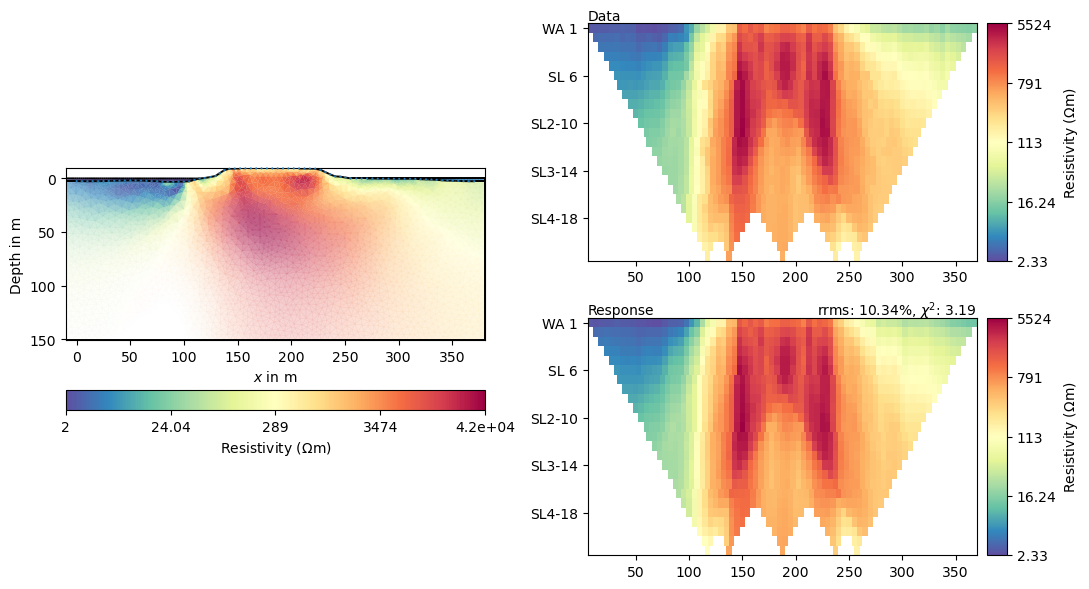

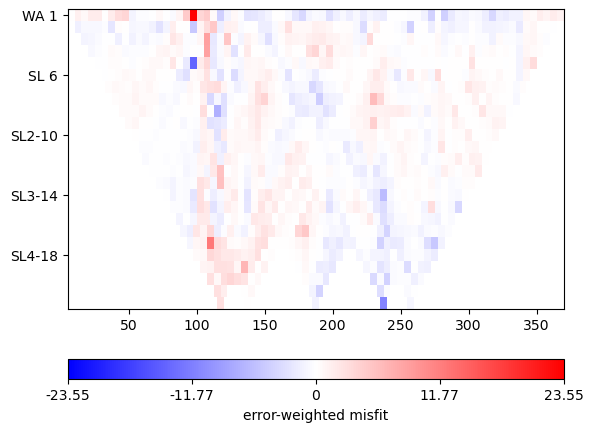

In [125]:
mgr.setMesh(mesh)


mgr.inv.setRegularization(3, limits=[1, 2], trans="log")
mgr.inv.setRegularization(4, limits=[2.5, 5], trans="log")



inv = mgr.invert(lam=20, verbose=True)

mgr.showResultAndFit()
mgr.showMisfit(errorWeighted=True)

In [ ]:
def run_inv(referencemodel):
    # Set reference model as startmodel
    mgr.inv.inv.setModel(referencemodel)

    # Set reference model
    rm = mgr.inv.fop.regionManager()
    rm.setConstraintType(10) # 0 = reference model, 1 = first-order smoothing (default), 10 = both
    rm.fillConstraints(mgr.inv.fop.constraints())
    mgr.inv.inv.setReferenceModel(referencemodel)
    model = mgr.inv.inv.run()
    return model

def compute_DOI(ref1, ref2):
    m1 = run_inv(ref1)
    m2 = run_inv(ref2)

    R = (m1 - m2) / (m1r - m2r)
    return R


m1r = np.ones(mgr.paraDomain.cellCount()) * 10000
m2r = np.ones(mgr.paraDomain.cellCount()) * 50

DOI = compute_DOI(m1r, m2r)

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10,7), dpi=150, sharex=True)

mgr.showResult(ax=ax1, orientation="vertical")
#ax1.set_xlabel("Profile length")
ax1.set_ylabel("y (m)")
pg.show(mgr.paraDomain, DOI, ax=ax2, cMin=0, cMax=1, orientation="vertical", label="DOI (-)")
ax2.set_xlabel("Profile length (m)")
ax2.set_ylabel("y (m)")

21/02/25 - 09:53:24 - pyGIMLi - INFO - Found 4 regions.
21/02/25 - 09:53:24 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
21/02/25 - 09:53:25 - pyGIMLi - INFO - Creating forward mesh from region infos.
21/02/25 - 09:53:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
21/02/25 - 09:53:26 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 7183 Cells: 13800 Boundaries: 10632
21/02/25 - 09:53:27 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 09:53:27 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 09:53:27 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2B90>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   31.14 (dPhi = 89.30%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    9.25 (dPhi = 43.05%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    9.55 (dPhi = 4.46%) lam: 1000.0


21/02/25 - 10:00:45 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:00:45 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:00:45 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3370>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1AF0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   30.66 (dPhi = 89.91%) lam: 799.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    8.24 (dPhi = 47.05%) lam: 799.9
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    8.17 (dPhi = 5.35%) lam: 799.9
---

21/02/25 - 10:08:58 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:08:58 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:08:58 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1AF0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2340>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   30.96 (dPhi = 90.35%) lam: 639.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    7.51 (dPhi = 51.42%) lam: 639.9
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    7.01 (dPhi = 6.44%) lam: 639.9
---

21/02/25 - 10:18:12 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:18:12 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:18:12 - pyGIMLi - INFO - Starting inversion.


chi² =    6.68 (dPhi = 0.95%) lam: 639.9
################################################################################
#                Abort criterion reached: dPhi = 0.95 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1540>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   31.06 (dPhi = 90.70%) lam: 

21/02/25 - 10:25:51 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:25:51 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:25:51 - pyGIMLi - INFO - Starting inversion.


chi² =    5.73 (dPhi = 1.19%) lam: 511.9
################################################################################
#                Abort criterion reached: dPhi = 1.19 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   31.44 (dPhi = 90.94%) lam: 

21/02/25 - 10:32:23 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:32:23 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:32:23 - pyGIMLi - INFO - Starting inversion.


chi² =    5.16 (dPhi = 10.49%) lam: 409.5
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    4.94 (dPhi = 1.42%) lam: 409.5
################################################################################
#                Abort criterion reached: dPhi = 1.42 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  4

21/02/25 - 10:39:22 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:39:22 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:39:22 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   32.96 (dPhi = 91.11%) lam: 262.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.59 (dPhi = 66.13%) lam: 262.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.89 (dPhi = 17.72%) lam: 262.0
--

21/02/25 - 10:47:05 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:47:05 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:47:05 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1690>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1540>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   34.06 (dPhi = 91.07%) lam: 209.6
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.67 (dPhi = 68.98%) lam: 209.6
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.43 (dPhi = 22.45%) lam: 209.6
--

21/02/25 - 10:54:30 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 10:54:30 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 10:54:30 - pyGIMLi - INFO - Starting inversion.


chi² =    3.19 (dPhi = 0.50%) lam: 209.6
################################################################################
#                 Abort criterion reached: dPhi = 0.5 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1AF0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2B90>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   35.58 (dPhi = 90.93%) lam: 

21/02/25 - 11:02:45 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:02:45 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:02:45 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1540>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1AF0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   36.96 (dPhi = 90.76%) lam: 134.1
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.82 (dPhi = 73.96%) lam: 134.1
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.81 (dPhi = 32.24%) lam: 134.1
--

21/02/25 - 11:09:09 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:09:09 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:09:09 - pyGIMLi - INFO - Starting inversion.


chi² =    2.65 (dPhi = 3.24%) lam: 134.1
--------------------------------------------------------------------------------
inv.iter 5 ... chi² =    2.54 (dPhi = 0.79%) lam: 134.1
################################################################################
#                Abort criterion reached: dPhi = 0.79 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2B90>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1690>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  44

21/02/25 - 11:15:51 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:15:51 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:15:51 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   39.96 (dPhi = 90.31%) lam: 85.8
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.87 (dPhi = 77.80%) lam: 85.8
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.46 (dPhi = 41.11%) lam: 85.8
-----

21/02/25 - 11:24:29 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:24:29 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:24:29 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1AF0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2340>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C03C0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   41.57 (dPhi = 90.05%) lam: 68.7
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.71 (dPhi = 79.72%) lam: 68.7
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.33 (dPhi = 44.18%) lam: 68.7
-----

21/02/25 - 11:30:49 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:30:49 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:30:49 - pyGIMLi - INFO - Starting inversion.


chi² =    2.04 (dPhi = 6.21%) lam: 68.7
--------------------------------------------------------------------------------
inv.iter 5 ... chi² =    1.97 (dPhi = 1.40%) lam: 68.7
################################################################################
#                 Abort criterion reached: dPhi = 1.4 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3370>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x000002903A3747B0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A375BD0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.

21/02/25 - 11:37:26 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:37:26 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:37:26 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C03C0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   44.31 (dPhi = 89.57%) lam: 43.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.51 (dPhi = 82.48%) lam: 43.9
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.22 (dPhi = 49.26%) lam: 43.9
-----

21/02/25 - 11:44:59 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:44:59 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:44:59 - pyGIMLi - INFO - Starting inversion.


chi² =    1.71 (dPhi = 1.80%) lam: 43.9
################################################################################
#                 Abort criterion reached: dPhi = 1.8 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3370>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A3747B0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   45.57 (dPhi = 89.34%) lam: 3

21/02/25 - 11:54:08 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 11:54:08 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 11:54:08 - pyGIMLi - INFO - Starting inversion.


chi² =    1.57 (dPhi = 0.67%) lam: 35.1
################################################################################
#                Abort criterion reached: dPhi = 0.67 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3370>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A3747B0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   46.68 (dPhi = 89.14%) lam: 2

21/02/25 - 12:04:11 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:04:11 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:04:11 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1AF0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3370>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   47.74 (dPhi = 88.93%) lam: 22.5
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.28 (dPhi = 85.19%) lam: 22.5
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.23 (dPhi = 53.29%) lam: 22.5
-----

21/02/25 - 12:14:14 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:14:14 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:14:14 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3370>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1540>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   48.83 (dPhi = 88.72%) lam: 18.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.31 (dPhi = 85.71%) lam: 18.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.25 (dPhi = 54.42%) lam: 18.0
-----

21/02/25 - 12:23:05 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:23:05 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:23:05 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C03C0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   50.01 (dPhi = 88.48%) lam: 14.4
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.60 (dPhi = 85.68%) lam: 14.4
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.34 (dPhi = 56.13%) lam: 14.4
-----

21/02/25 - 12:32:26 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:32:26 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:32:26 - pyGIMLi - INFO - Starting inversion.


chi² =    1.20 (dPhi = 0.19%) lam: 14.4
################################################################################
#                Abort criterion reached: dPhi = 0.19 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A3747B0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   51.39 (dPhi = 88.19%) lam: 1

21/02/25 - 12:40:43 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:40:43 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:40:43 - pyGIMLi - INFO - Starting inversion.


chi² =    1.13 (dPhi = 0.32%) lam: 11.5
################################################################################
#                Abort criterion reached: dPhi = 0.32 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C03C0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A3747B0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   53.13 (dPhi = 87.81%) lam: 9

21/02/25 - 12:50:10 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:50:10 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:50:10 - pyGIMLi - INFO - Starting inversion.


chi² =    1.07 (dPhi = 0.54%) lam: 9.2
################################################################################
#                Abort criterion reached: dPhi = 0.54 (< 2.0%)                 #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C03C0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A375BD0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   55.22 (dPhi = 87.36%) lam: 7.

21/02/25 - 12:58:37 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 12:58:37 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 12:58:37 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C03C0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C04A0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   57.71 (dPhi = 86.81%) lam: 5.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   10.46 (dPhi = 81.48%) lam: 5.9
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.54 (dPhi = 71.89%) lam: 5.9
--------

21/02/25 - 13:06:13 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 13:06:13 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 13:06:13 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2B90>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   60.70 (dPhi = 86.15%) lam: 4.7
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   12.65 (dPhi = 78.89%) lam: 4.7
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.76 (dPhi = 75.29%) lam: 4.7
--------

21/02/25 - 13:13:29 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 13:13:29 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 13:13:29 - pyGIMLi - INFO - Starting inversion.


chi² =    0.90 (dPhi = 17.74%) lam: 4.7


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.90)                   #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2340>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1690>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A3747B0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   64.20 (dPhi = 85.37%) lam:

21/02/25 - 13:21:15 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 13:21:15 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 13:21:15 - pyGIMLi - INFO - Starting inversion.


chi² =    0.90 (dPhi = 7.12%) lam: 3.8


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.90)                   #
################################################################################
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1690>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1B60>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x000002903A375BD0>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   67.96 (dPhi = 84.54%) lam: 

21/02/25 - 13:29:24 - pyGIMLi - INFO - Use median(data values)=598.1559000395198
21/02/25 - 13:29:24 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 13:29:24 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1540>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C2340>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1690>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   72.10 (dPhi = 83.62%) lam: 2.4
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   21.31 (dPhi = 70.38%) lam: 2.4
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.19 (dPhi = 74.47%) lam: 2.4
--------

21/02/25 - 13:40:00 - pyGIMLi - INFO - Use median(data values)=598.1559000395198


chi² =    0.91 (dPhi = 16.25%) lam: 2.4


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.91)                   #
################################################################################


21/02/25 - 13:40:00 - pyGIMLi - INFO - Created startmodel from forward operator: 3028, min/max=598.155900/598.155900
21/02/25 - 13:40:00 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000290462AFC40>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000029041ECD440>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1E70>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C1EE0>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000290418C3220>
min/max (data): 2.33/5525
min/max (error): 5%/2834%
min/max (start model): 598/598
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  443.62
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   76.37 (dPhi = 82.67%) lam: 1.9
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   23.97 (dPhi = 68.57%) lam: 1.9
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    6.51 (dPhi = 71.98%) lam: 1.9
--------

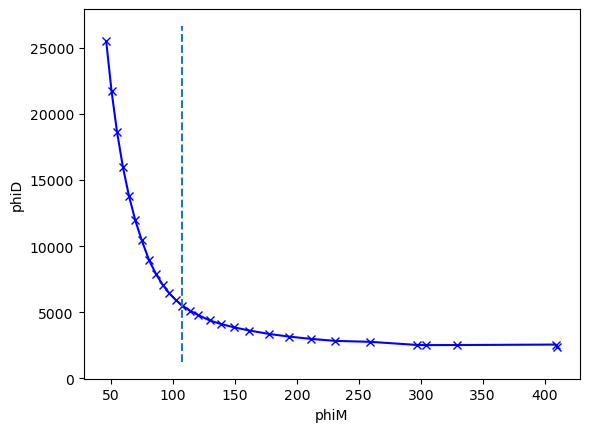

In [100]:
mgr.setMesh(mesh)


mgr.inv.setRegularization(3, limits=[1, 2], trans="log")
mgr.inv.setRegularization(4, limits=[2.5, 5], trans="log")
#mgr.inv.setRegularization(2, zWeight=0.9)

lambdas = np.logspace(np.log10(1000), np.log10(1.93), num=29)
phiD = []
phiM = []
for lam in lambdas:
    mgr.invert(data, lam=lam, verbose=True)
    phiD.append(mgr.inv.phiData())
    phiM.append(mgr.inv.phiModel())

phiD = np.array(phiD)
phiM = np.array(phiM)

from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(phiM, phiD, S=1.0, curve="convex", direction="decreasing",interp_method='interp1d')

print(round(kneedle.elbow, 3))
print(round(kneedle.knee_y, 3))
print(lambdas[np.where(phiM==kneedle.knee)[0]])

plt.xlabel('phiM')
plt.ylabel('phiD')
plt.plot(phiM, phiD, 'bx-')
plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')


149.203
3853.577
[22.48772434]


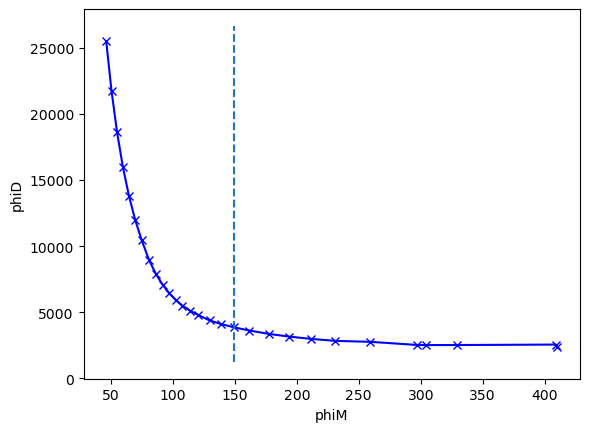

In [101]:
from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(phiM, phiD, online=True, curve="convex", direction="decreasing",interp_method='polynomial', polynomial_degree=3)

print(round(kneedle.elbow, 3))
print(round(kneedle.elbow_y, 3))
print(lambdas[np.where(phiM==kneedle.elbow)[0]])

plt.xlabel('phiM')
plt.ylabel('phiD')
plt.plot(phiM, phiD, 'bx-')
plt.vlines(kneedle.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')



21/02/25 - 20:59:11 - pyGIMLi - INFO - Saving inversion results to: //smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/pygimli/all_inversions/INV_eastern_new_rhoa_mike\ERTManager


Path //smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/pygimli/all_inversions/INV_eastern_new_rhoa_mike\ERTManager already exists. Skipping


('//smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/pygimli/all_inversions/INV_eastern_new_rhoa_mike\\ERTManager',
 <Figure size 1600x1000 with 2 Axes>,
 <Axes: xlabel='$x$ in m', ylabel='Depth in m'>)

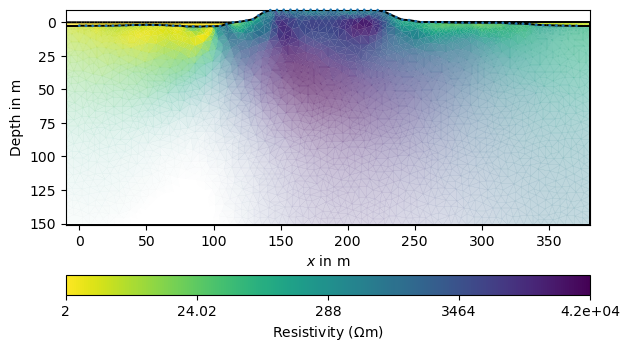

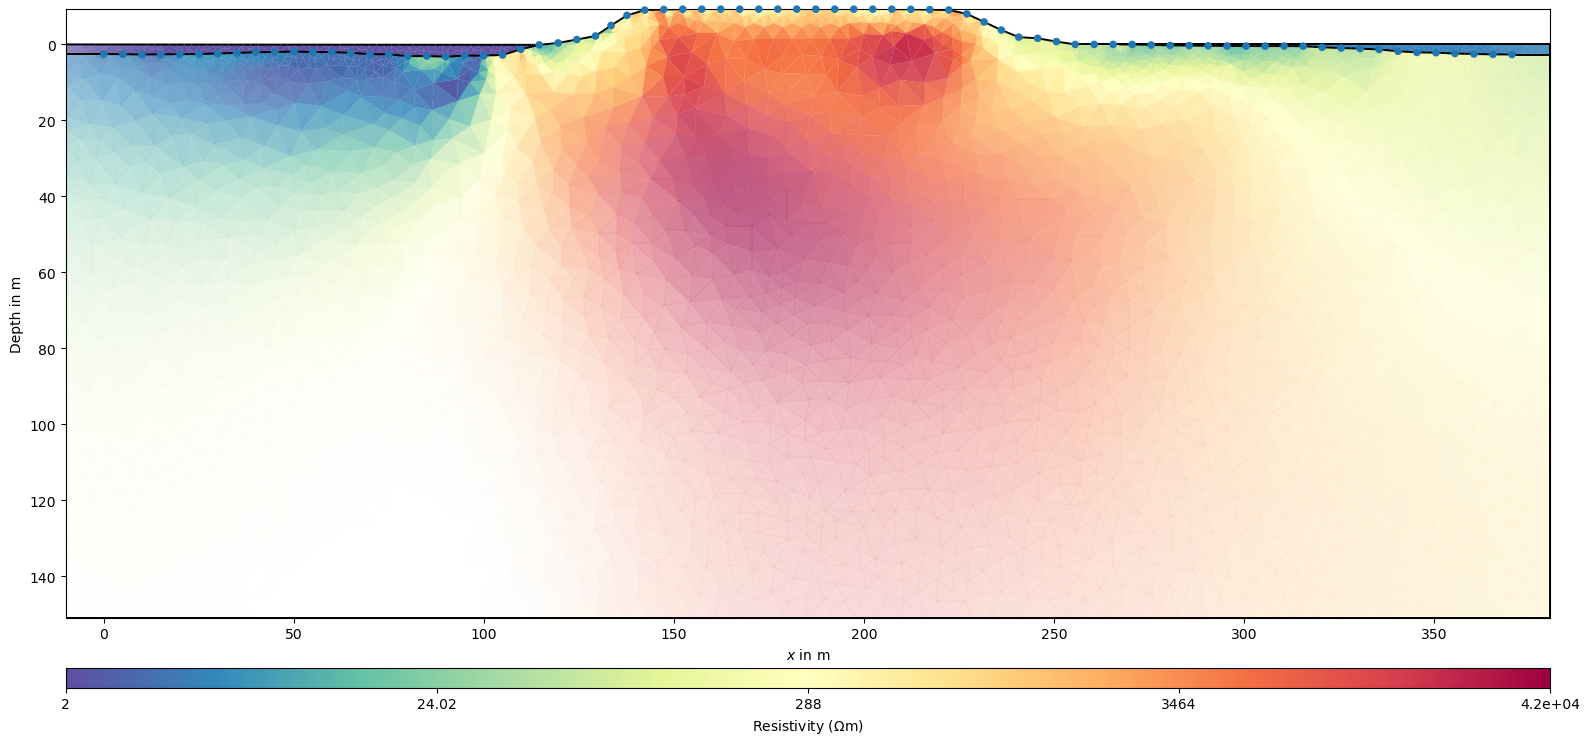

In [121]:
mgr.showResult(cMap="viridis_r", logScale=True)
mgr.saveResult(dir + 'pygimli/all_inversions/INV_eastern_new_rhoa_mike')

In [122]:
with open(dir+'processing/shoreline/joined_east.pkl', 'rb') as f:
    joined_east = pickle.load(f)

In [123]:
eastshore = joined_east[['year', 'xc', 'zc']].to_numpy()
eastshore[:, 1] = eastshore[:, 1].round(decimals=0)
eastshore[:, 2] = eastshore[:, 2].round(decimals=1)


In [124]:
posVec2 = [pg.Pos(pos) for pos in zip(eastshore[:, 1], eastshore[:, 2])]
para = pg.Mesh(mgr.paraDomain)
para.setCellMarkers(pg.IVector(para.cellCount()))




fopDP = PriorModelling(para, posVec2)


resMesh = fopDP(mgr.model)



cov = fopDP(mgr.coverage())

east_shoreline_plots = np.column_stack((eastshore[:, 1], eastshore[:, 2], resMesh, eastshore[:, 0], cov,))
east_shoreline_plots = np.c_[ east_shoreline_plots, 2023 - east_shoreline_plots[:, 3] ]
column_titles = "X,Y,ResMesh,Year,Cov,Age"
np.savetxt(
    dir+'processing/shoreline/east_shoreline_plots.csv', 
    east_shoreline_plots, 
    delimiter=',', 
    header=column_titles, 
    comments=''  # Removes the '#' added to the header line by default
)

21/02/25 - 23:23:07 - pyGIMLi - INFO - Found 1 regions.
